<a href="https://colab.research.google.com/github/ZuraizBaig/DSP-R-peak-Detection-and-Classification/blob/main/Alzheimer's_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Creating New Images

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Specify the path to your dataset
data_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset'  # Update with your actual path
desired_size = 2000  # Change this value to 2000 for each class

# Create an ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Create an empty directory to store the augmented images
augmented_dir = '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset'
os.makedirs(augmented_dir, exist_ok=True)

# Iterate through the subdirectories (classes) in the dataset directory
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = sum([len(files) for _, _, files in os.walk(class_path)])
        if count < desired_size:
            additional_images = desired_size - count
            augmented_class_path = os.path.join(augmented_dir, class_name)
            os.makedirs(augmented_class_path, exist_ok=True)

            generator = datagen.flow_from_directory(
                data_dir,
                target_size=(128, 128),
                batch_size=32,
                class_mode='categorical',
                classes=[class_name],
                save_to_dir=augmented_class_path,
                save_prefix='augmented',
                save_format='jpeg',
                subset='training'
            )

            batches = additional_images // 32
            print(f"Generating {additional_images} augmented images for class {class_name}")
            for i in range(batches):
                batch = generator.next()

# Now, you can use the images in the 'new_dataset' directory for training


Found 717 images belonging to 1 classes.
Generating 1104 augmented images for class Mild_Demented


KeyboardInterrupt: ignored

#Deleting created Images

In [ ]:
import os

# Specify the path to your Google Drive directory
drive_path = '/content/drive/MyDrive'  # Replace with your actual path

# Specify the file extension you want to delete
file_extension = '.jpeg'

# Iterate through all files in the directory
for root, dirs, files in os.walk(drive_path):
    for file_name in files:
        if file_name.lower().endswith(file_extension):
            file_path = os.path.join(root, file_name)
            try:
                os.unlink(file_path)
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")


In [ ]:
import os

# Specify the path to your Google Drive directory
drive_path = '/content/drive/MyDrive'  # Replace with your actual path

# Specify the prefix of the files you want to delete
file_prefix = 'augmented'

count = 0

# Iterate through all files in the directory
for root, dirs, files in os.walk(drive_path):
    for file_name in files:
        if file_name.startswith(file_prefix):
            file_path = os.path.join(root, file_name)
            try:
                os.unlink(file_path)
                print(f"Deleted: {file_path}")
                count = count + 1
                print(f"Count: {count}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")

print("Final Count :",count )


Final Count : 0


#Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["figure.figsize"] = (30,6)
#plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

# Data Handling

## Visualizing dataset

A search has been initiated within the folder named 'Dataset'.
There are 896 images in the Mild_Demented folder.
There are 2250 images in the Very_Mild_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 3200 images in the Non_Demented folder.
The search has been completed.


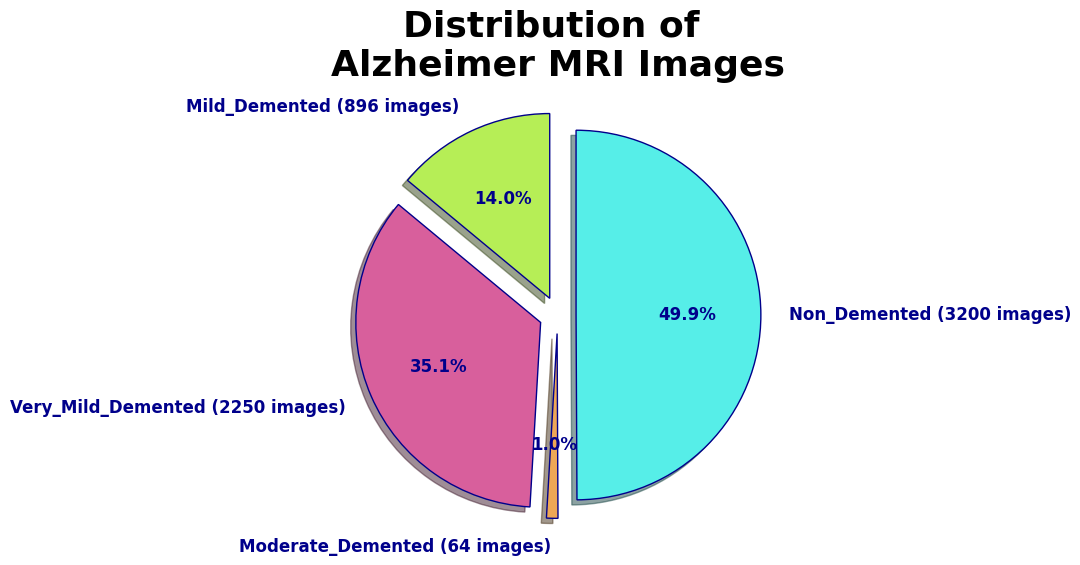

In [ ]:
class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1

            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')

    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)

    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]

    plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors, textprops={'fontsize': 12, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
           {'edgecolor':'darkblue'} , labeldistance=1.15)
    plt.title("Distribution of \nAlzheimer MRI Images", size=26, fontweight="bold")

PATH = '/content/drive/MyDrive/Colab Notebooks/Dataset'

image_counter(PATH)

# Looking Inside Directories

In [ ]:
import os

# Specify the path to the folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset/Mild_Demented'

# Get the list of files in the folder
files = os.listdir(folder_path)

# Filter only the files with image extensions (e.g., '.jpg', '.png')
image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]

# Calculate the number of images
num_images = len(image_files)

print(f"Number of images in '{folder_path}': {num_images}")


Number of images in '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset/Mild_Demented': 1197


In [ ]:
#Specify the path to the folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset/Moderate_Demented'

# Get the list of files in the folder
files = os.listdir(folder_path)

# Filter only the files with image extensions (e.g., '.jpg', '.png')
image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]

# Calculate the number of images
num_images = len(image_files)

print(f"Number of images in '{folder_path}': {num_images}")

Number of images in '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset/Moderate_Demented': 1560


In [ ]:
#Specify the path to the folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset/Very_Mild_Demented'

# Get the list of files in the folder
files = os.listdir(folder_path)

# Filter only the files with image extensions (e.g., '.jpg', '.png')
image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]

# Calculate the number of images
num_images = len(image_files)

print(f"Number of images in '{folder_path}': {num_images}")

Number of images in '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset/Very_Mild_Demented': 0


In [ ]:
#Specify the path to the folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset/Non_Demented'

# Get the list of files in the folder
files = os.listdir(folder_path)

# Filter only the files with image extensions (e.g., '.jpg', '.png')
image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]

# Calculate the number of images
num_images = len(image_files)

print(f"Number of images in '{folder_path}': {num_images}")

Number of images in '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset/Non_Demented': 0


#Combining Created Original Images and their Labels

Number of Non Demented images from augmented dataset: 0
Number of Non Demented images from original dataset: 3200
Total number of combined Non Demented images: 3200
Total number of combined Non Demented labels: 3200


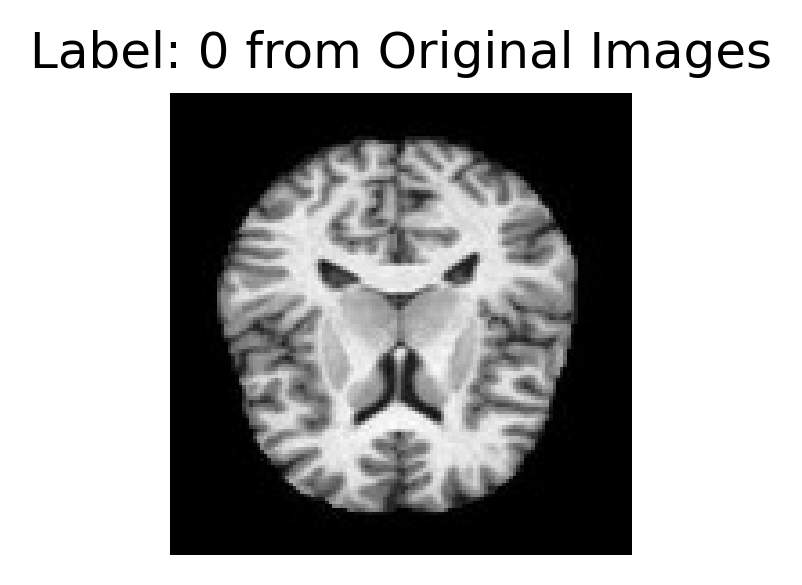

In [ ]:
import os
import cv2

# Function to load images and extract labels from a folder
def load_images_and_labels_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            images.append(image)
            labels.append(label)  # Assuming the label is the same for all images in this folder
    return images, labels

# Specify the paths to the folders
augmented_data_folder = '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset/Non_Demented'
original_data_folder = '/content/drive/MyDrive/Colab Notebooks/Dataset/Non_Demented'

# Load images and labels from both folders
augmented_images, augmented_labels = load_images_and_labels_from_folder(augmented_data_folder, label=0)
original_images, original_labels = load_images_and_labels_from_folder(original_data_folder, label=0)

# Combine the datasets
combined_Non_D_images = augmented_images + original_images
combined_Non_D_labels = augmented_labels + original_labels

# Print the number of images and labels loaded
print(f"Number of Non Demented images from augmented dataset: {len(augmented_images)}")
print(f"Number of Non Demented images from original dataset: {len(original_images)}")
print(f"Total number of combined Non Demented images: {len(combined_Non_D_images)}")
print(f"Total number of combined Non Demented labels: {len(combined_Non_D_labels)}")

"""
# Assuming combined_Non_D_images[1000] is your image and combined_Non_D_labels[1000] is its label
image_to_view = augmented_images[1000]
label_to_view = augmented_labels[1000]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view} from Augmented Images")
plt.axis('off')
plt.show()
"""

# Assuming combined_Non_D_images[1000] is your image and combined_Non_D_labels[1000] is its label
image_to_view = original_images[1000]
label_to_view = original_labels[1000]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view} from Original Images")
plt.axis('off')
plt.show()


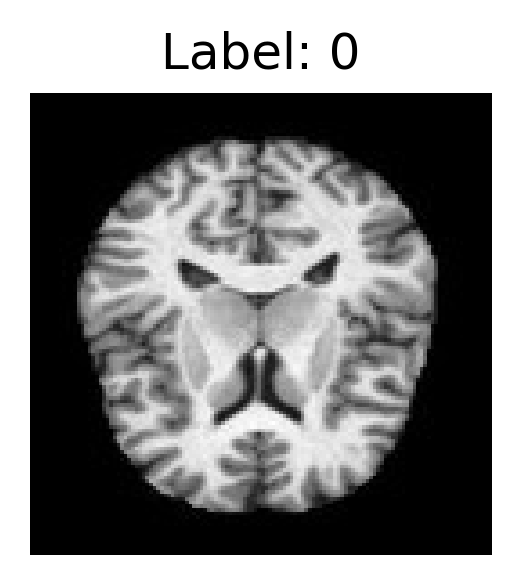

In [ ]:
# Assuming combined_Non_D_images[1000] is your image and combined_Non_D_labels[1000] is its label
image_to_view = combined_Non_D_images[1000]
label_to_view = combined_Non_D_labels[1000]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view}")
plt.axis('off')
plt.show()


Number of Mild Demented images from augmented dataset: 1197
Number of Mild Demented images from original dataset: 896
Total number of combined Mild Demented images: 2093
Total number of combined Mild Demented labels: 2093


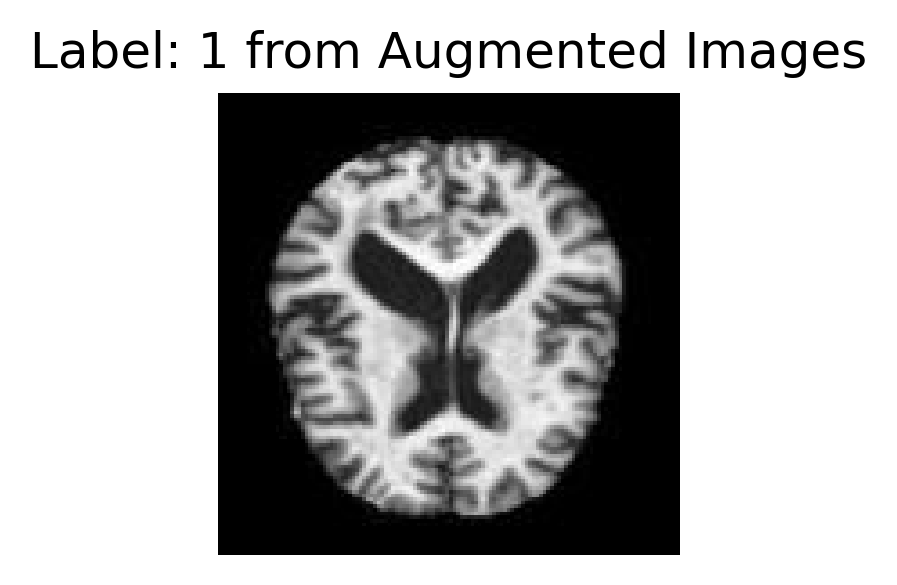

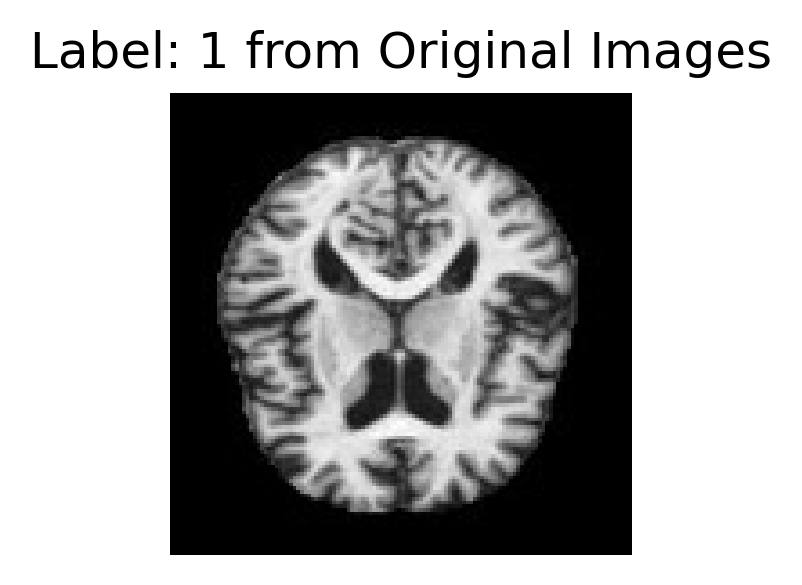

In [ ]:
# Specify the paths to the folders
augmented_data_folder = '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset/Mild_Demented'
original_data_folder = '/content/drive/MyDrive/Colab Notebooks/Dataset/Mild_Demented'

# Load images and labels from both folders
augmented_images, augmented_labels = load_images_and_labels_from_folder(augmented_data_folder, label=1)
original_images, original_labels = load_images_and_labels_from_folder(original_data_folder, label=1)

# Combine the datasets
combined_Mild_D_images = augmented_images + original_images
combined_Mild_D_labels = augmented_labels + original_labels

# Print the number of images and labels loaded
print(f"Number of Mild Demented images from augmented dataset: {len(augmented_images)}")
print(f"Number of Mild Demented images from original dataset: {len(original_images)}")
print(f"Total number of combined Mild Demented images: {len(combined_Mild_D_images)}")
print(f"Total number of combined Mild Demented labels: {len(combined_Mild_D_labels)}")


# Assuming combined_Non_D_images[1000] is your image and combined_Non_D_labels[1000] is its label
image_to_view = augmented_images[1000]
label_to_view = augmented_labels[1000]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view} from Augmented Images")
plt.axis('off')
plt.show()


# Assuming combined_Non_D_images[1000] is your image and combined_Non_D_labels[1000] is its label
image_to_view = original_images[500]
label_to_view = original_labels[500]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view} from Original Images")
plt.axis('off')
plt.show()

In [ ]:
print(combined_Mild_D_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

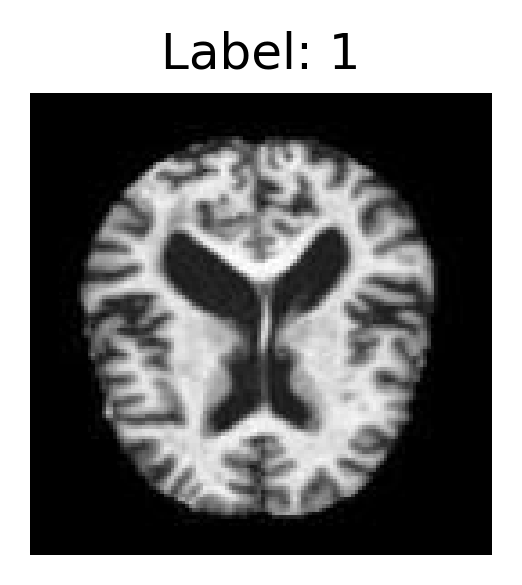

In [ ]:
image_to_view = combined_Mild_D_images[1000]
label_to_view = combined_Mild_D_labels[1000]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view}")
plt.axis('off')
plt.show()

Number of Very_Mild Demented images from augmented dataset: 0
Number of Very_Mild Demented images from original dataset: 2250
Total number of combined Very_Mild Demented images: 2250
Total number of combined Very_Mild Demented labels: 2250


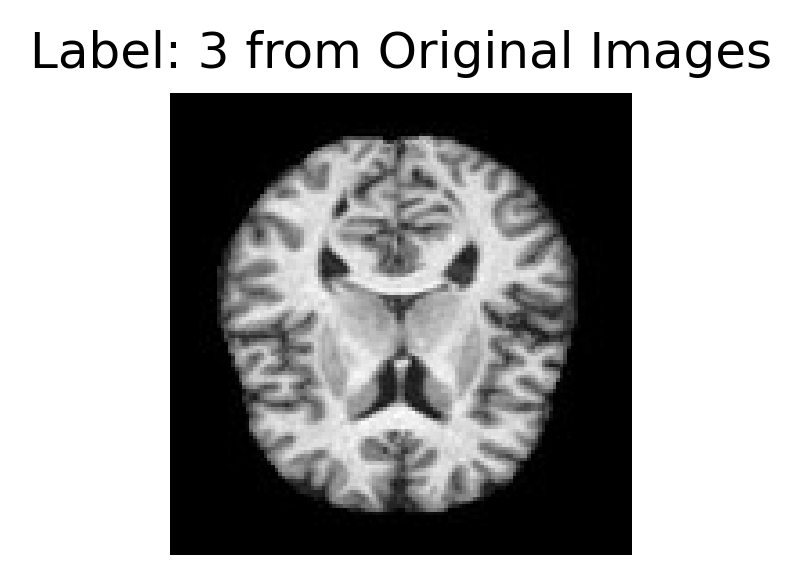

In [ ]:
# Specify the paths to the folders
augmented_data_folder = '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset/Very_Mild_Demented'
original_data_folder = '/content/drive/MyDrive/Colab Notebooks/Dataset/Very_Mild_Demented'

# Load images and labels from both folders
augmented_images, augmented_labels = load_images_and_labels_from_folder(augmented_data_folder, label=3)
original_images, original_labels = load_images_and_labels_from_folder(original_data_folder, label=3)

# Combine the datasets
combined_Very_Mild_D_images = augmented_images + original_images
combined_Very_Mild_D_labels = augmented_labels + original_labels

# Print the number of images and labels loaded
print(f"Number of Very_Mild Demented images from augmented dataset: {len(augmented_images)}")
print(f"Number of Very_Mild Demented images from original dataset: {len(original_images)}")
print(f"Total number of combined Very_Mild Demented images: {len(combined_Very_Mild_D_images)}")
print(f"Total number of combined Very_Mild Demented labels: {len(combined_Very_Mild_D_labels)}")

"""
# Assuming combined_Non_D_images[1000] is your image and combined_Non_D_labels[1000] is its label
image_to_view = augmented_images[1000]
label_to_view = augmented_labels[1000]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view} from Augmented Images")
plt.axis('off')
plt.show()
"""

# Assuming combined_Non_D_images[1000] is your image and combined_Non_D_labels[1000] is its label
image_to_view = original_images[1000]
label_to_view = original_labels[1000]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view} from Original Images")
plt.axis('off')
plt.show()

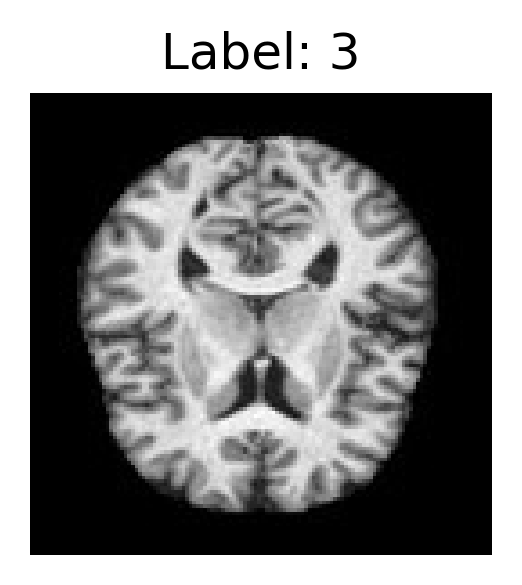

In [ ]:
image_to_view = combined_Very_Mild_D_images[1000]
label_to_view = combined_Very_Mild_D_labels[1000]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view}")
plt.axis('off')
plt.show()

Number of Moderate Demented images from augmented dataset: 1560
Number of Moderate Demented images from original dataset: 64
Total number of combined Moderate Demented images: 1624
Total number of combined Moderate Demented labels: 1624


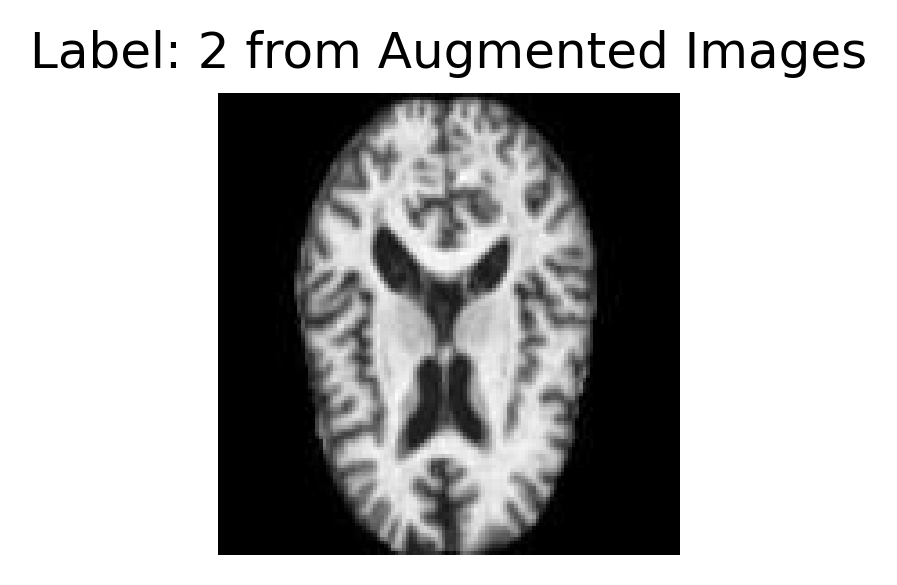

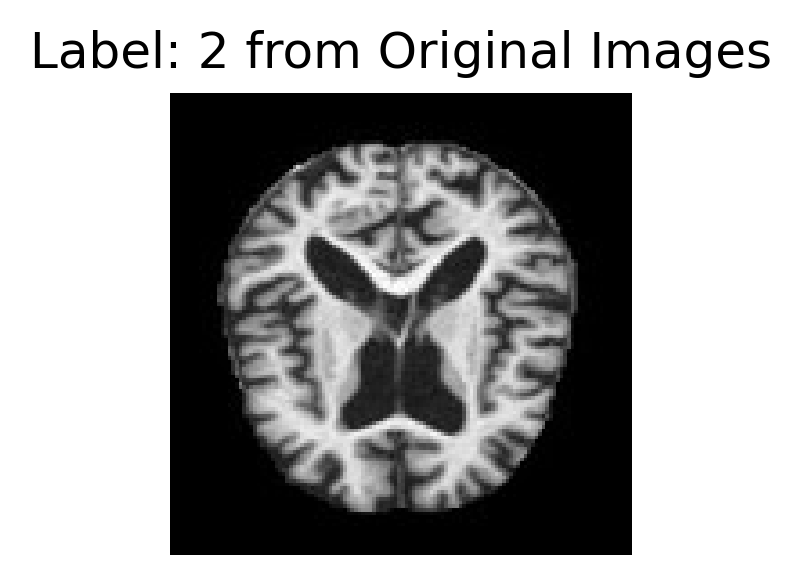

In [ ]:
# Specify the paths to the folders
augmented_data_folder = '/content/drive/MyDrive/Colab Notebooks/Augmented_Dataset/Moderate_Demented'
original_data_folder = '/content/drive/MyDrive/Colab Notebooks/Dataset/Moderate_Demented'

# Load images and labels from both folders
augmented_images, augmented_labels = load_images_and_labels_from_folder(augmented_data_folder, label=2)
original_images, original_labels = load_images_and_labels_from_folder(original_data_folder, label=2)

# Combine the datasets
combined_Moderate_D_images = augmented_images + original_images
combined_Moderate_D_labels = augmented_labels + original_labels

# Print the number of images and labels loaded
print(f"Number of Moderate Demented images from augmented dataset: {len(augmented_images)}")
print(f"Number of Moderate Demented images from original dataset: {len(original_images)}")
print(f"Total number of combined Moderate Demented images: {len(combined_Moderate_D_images)}")
print(f"Total number of combined Moderate Demented labels: {len(combined_Moderate_D_labels)}")

# Assuming combined_Non_D_images[1000] is your image and combined_Non_D_labels[1000] is its label
image_to_view = augmented_images[1000]
label_to_view = augmented_labels[1000]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view} from Augmented Images")
plt.axis('off')
plt.show()


# Assuming combined_Non_D_images[1000] is your image and combined_Non_D_labels[1000] is its label
image_to_view = original_images[40]
label_to_view = original_labels[40]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view} from Original Images")
plt.axis('off')
plt.show()

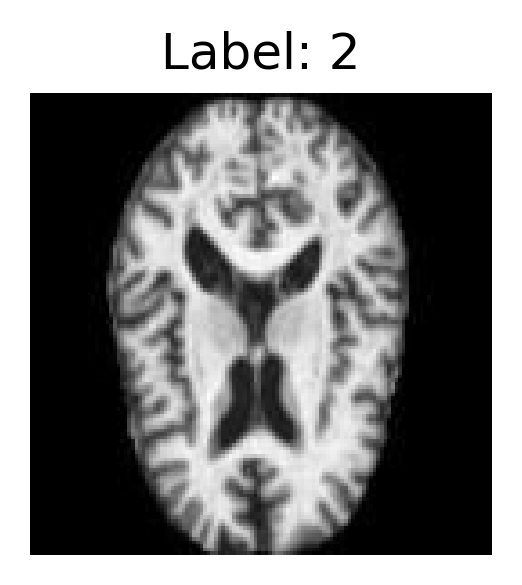

In [ ]:
image_to_view = combined_Moderate_D_images[1000]
label_to_view = combined_Moderate_D_labels[1000]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view}")
plt.axis('off')
plt.show()

In [ ]:
Total_Images = combined_Very_Mild_D_images[:1000] + combined_Moderate_D_images[:1000] + combined_Mild_D_images[:1000] + combined_Non_D_images[:1000]
print("Total Number of Images is :",len(Total_Images))
Total_labels = combined_Very_Mild_D_labels[:1000] + combined_Moderate_D_labels[:1000] + combined_Mild_D_labels[:1000] + combined_Non_D_labels[:1000]
print("Total Number of labels is :",len(Total_labels))

Total Number of Images is : 4000
Total Number of labels is : 4000


In [ ]:
"""
combined_Very_Mild_D_images = 0
combined_Moderate_D_images = 0
combined_Mild_D_images = 0
combined_Non_D_images = 0


combined_Very_Mild_D_labels = 0
combined_Moderate_D_labels = 0
combined_Mild_D_labels = 0
combined_Non_D_labels = 0
"""

'\ncombined_Very_Mild_D_images = 0\ncombined_Moderate_D_images = 0\ncombined_Mild_D_images = 0\ncombined_Non_D_images = 0\n\n\ncombined_Very_Mild_D_labels = 0\ncombined_Moderate_D_labels = 0\ncombined_Mild_D_labels = 0\ncombined_Non_D_labels = 0\n'

In [ ]:
print(Total_labels)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

#Train, Validation and Train Images

In [ ]:
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
seed = 42

# Split into train (70%), validation (20%), and test (10%) sets
train_images, test_images, train_labels, test_labels = train_test_split(Total_Images, Total_labels, test_size=0.1, random_state=seed, stratify=Total_labels)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=seed, stratify=train_labels)

# Print the sizes of each set
print(f"Number of training images: {len(train_images)}")
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of validation labels: {len(val_labels)}")
print(f"Number of test images: {len(test_images)}")
print(f"Number of test labels: {len(test_labels)}")

Number of training images: 2880
Number of training labels: 2880
Number of validation images: 720
Number of validation labels: 720
Number of test images: 400
Number of test labels: 400


In [ ]:
"""
Total_Images = 0
Total_labels = 0
"""

'\nTotal_Images = 0\nTotal_labels = 0\n'

In [ ]:
print(test_labels)

[1, 3, 0, 1, 0, 2, 1, 3, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 1, 2, 2, 2, 3, 2, 3, 2, 3, 3, 0, 2, 1, 1, 2, 0, 3, 2, 3, 1, 3, 3, 1, 2, 1, 2, 0, 0, 2, 3, 0, 3, 1, 3, 3, 2, 0, 3, 3, 0, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 3, 1, 2, 1, 0, 0, 1, 1, 3, 0, 3, 2, 2, 0, 2, 1, 3, 2, 2, 2, 0, 0, 2, 3, 1, 3, 2, 2, 2, 3, 3, 0, 3, 2, 0, 2, 1, 1, 1, 1, 0, 0, 1, 2, 3, 3, 1, 1, 3, 2, 3, 0, 2, 0, 0, 2, 0, 3, 0, 1, 3, 2, 3, 2, 0, 0, 1, 3, 2, 0, 3, 2, 1, 1, 3, 0, 3, 1, 0, 3, 0, 2, 2, 0, 1, 3, 1, 3, 2, 2, 2, 2, 1, 1, 0, 0, 2, 1, 3, 3, 0, 0, 3, 3, 2, 1, 3, 0, 1, 2, 3, 1, 2, 2, 0, 3, 2, 0, 1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 0, 3, 3, 3, 1, 1, 2, 3, 0, 0, 2, 1, 2, 3, 3, 1, 2, 0, 3, 0, 1, 3, 3, 1, 0, 0, 2, 3, 1, 3, 3, 0, 1, 1, 2, 1, 3, 3, 2, 1, 3, 1, 2, 3, 2, 3, 0, 1, 1, 0, 0, 2, 3, 0, 2, 0, 0, 3, 3, 3, 1, 1, 1, 0, 2, 0, 3, 3, 1, 1, 0, 0, 1, 3, 2, 1, 0, 0, 3, 0, 0, 2, 2, 1, 0, 1, 0, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 3, 0, 2, 3, 1, 2, 1, 3, 0, 2, 3, 2, 2, 2, 1, 0, 3, 3, 2, 1, 3, 2, 0, 1, 1, 0, 0, 0, 3, 2, 0, 3, 3, 0, 2, 

In [ ]:
import numpy as np

# Convert lists to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

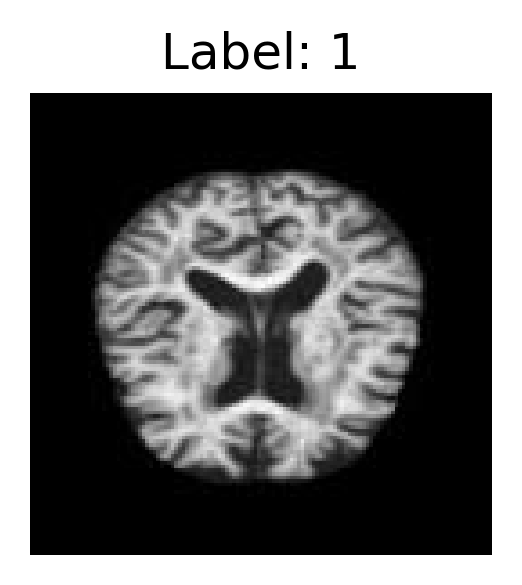

In [ ]:
image_to_view = train_images[1000]
label_to_view = train_labels[1000]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view}")
plt.axis('off')
plt.show()

In [ ]:
# Normalize pixel values to the range [0, 1]
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

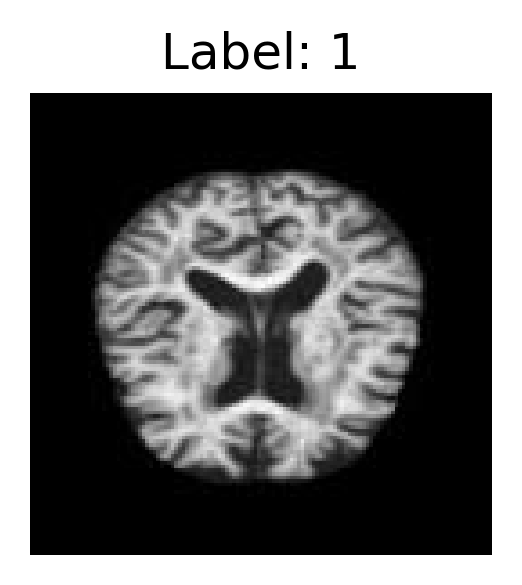

In [ ]:
image_to_view = train_images[1000]
label_to_view = train_labels[1000]

plt.figure(figsize=(2, 2))  # Adjust the dimensions as needed
# Visualize the image
plt.imshow(image_to_view)
plt.title(f"Label: {label_to_view}")
plt.axis('off')
plt.show()

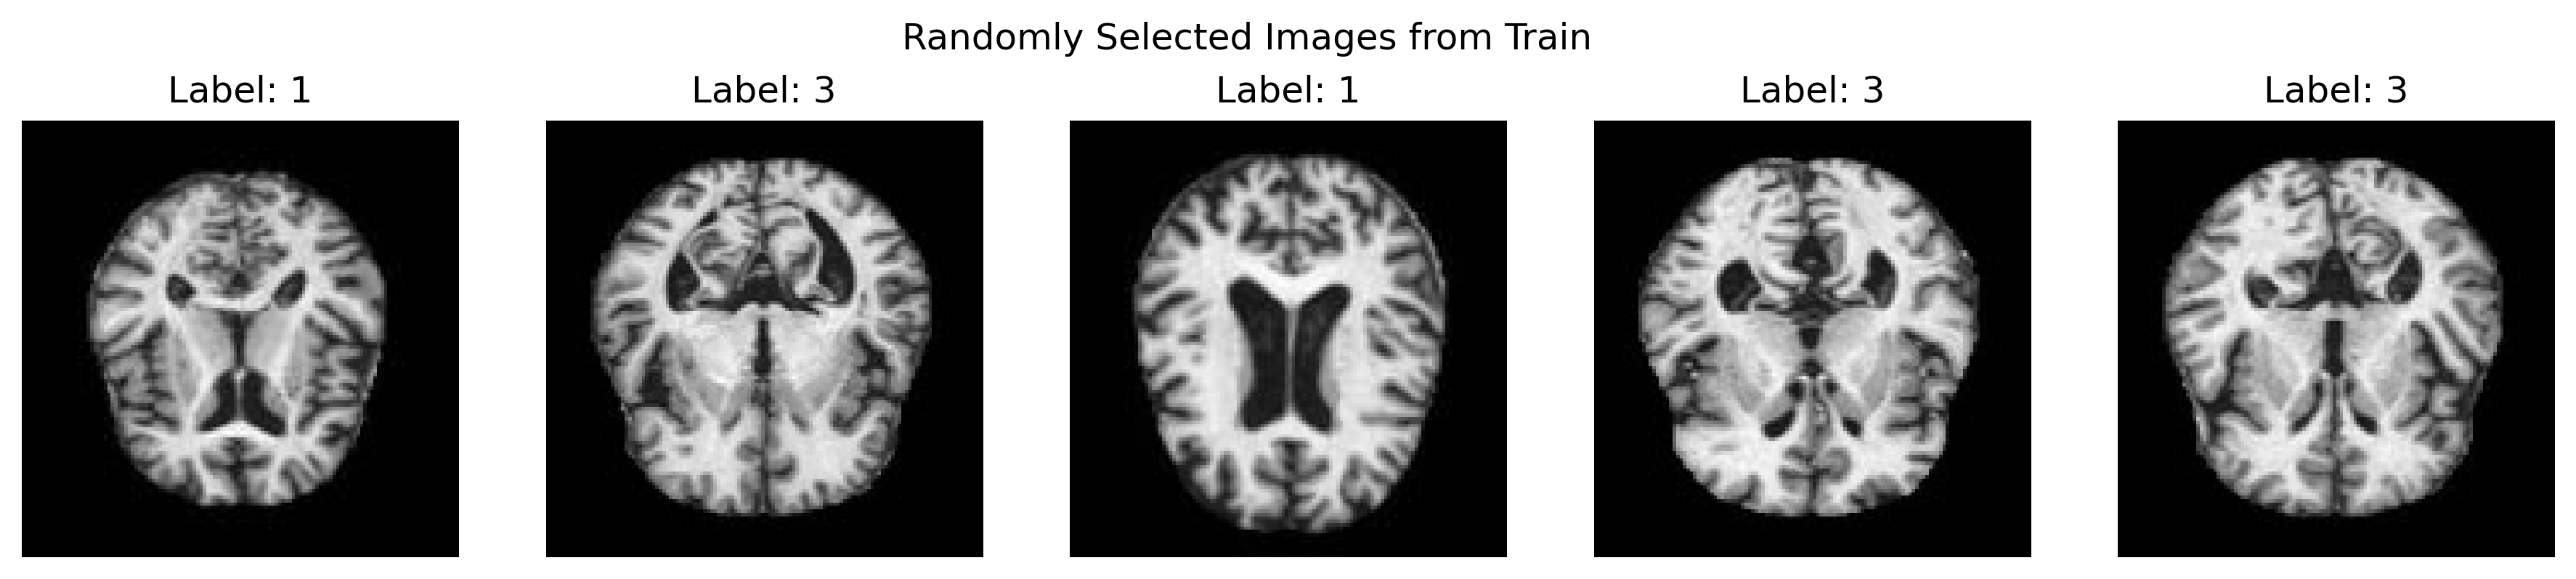

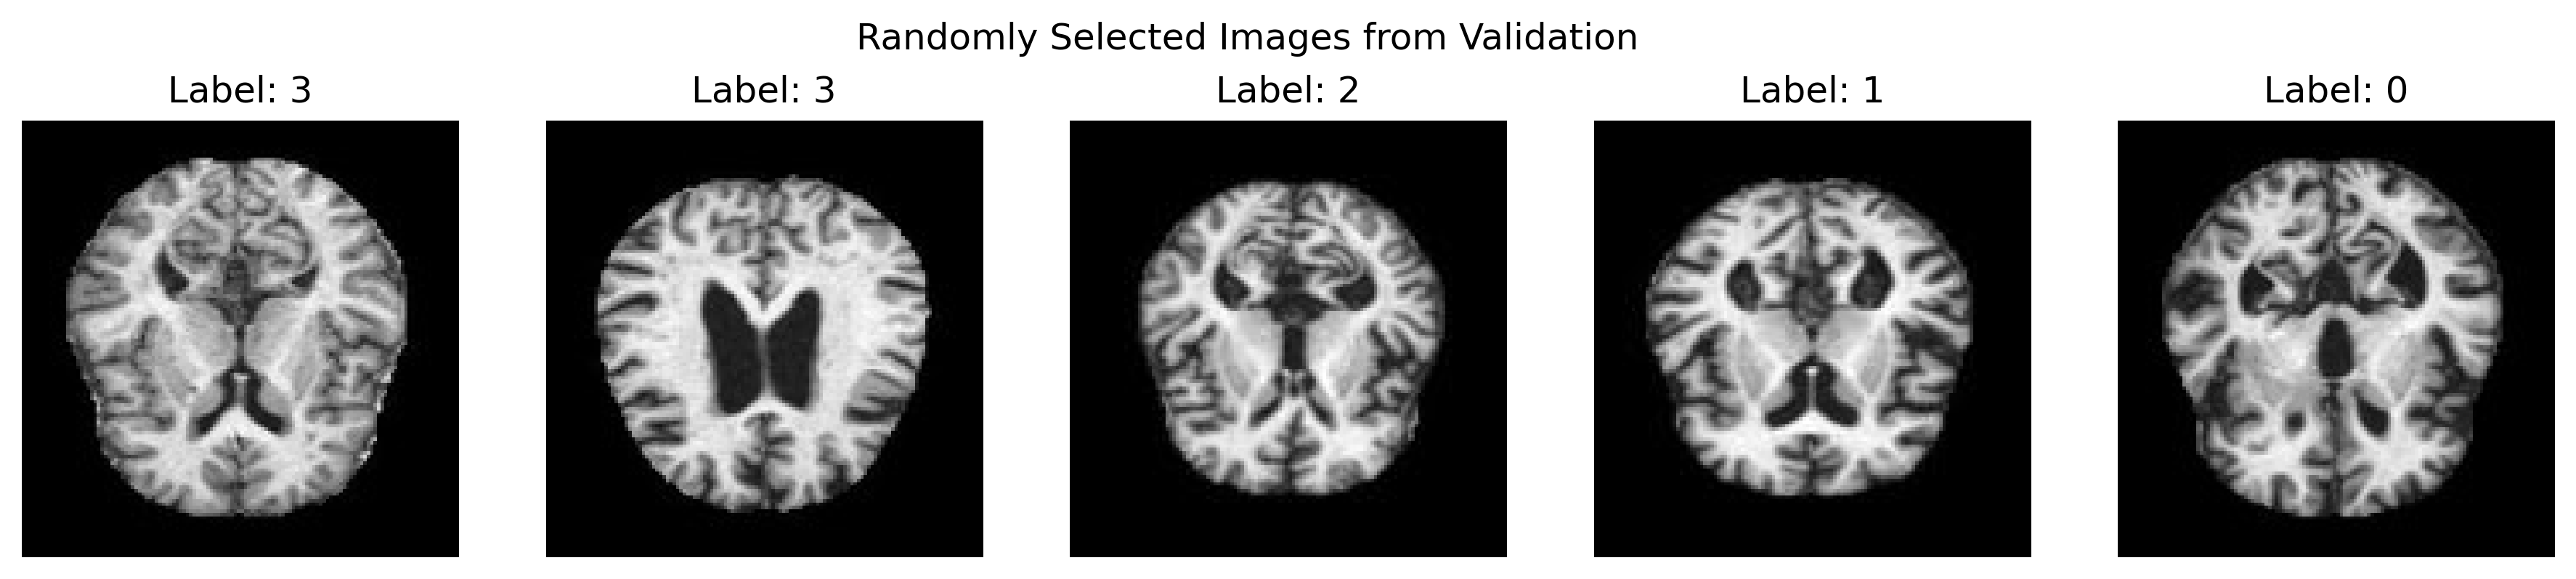

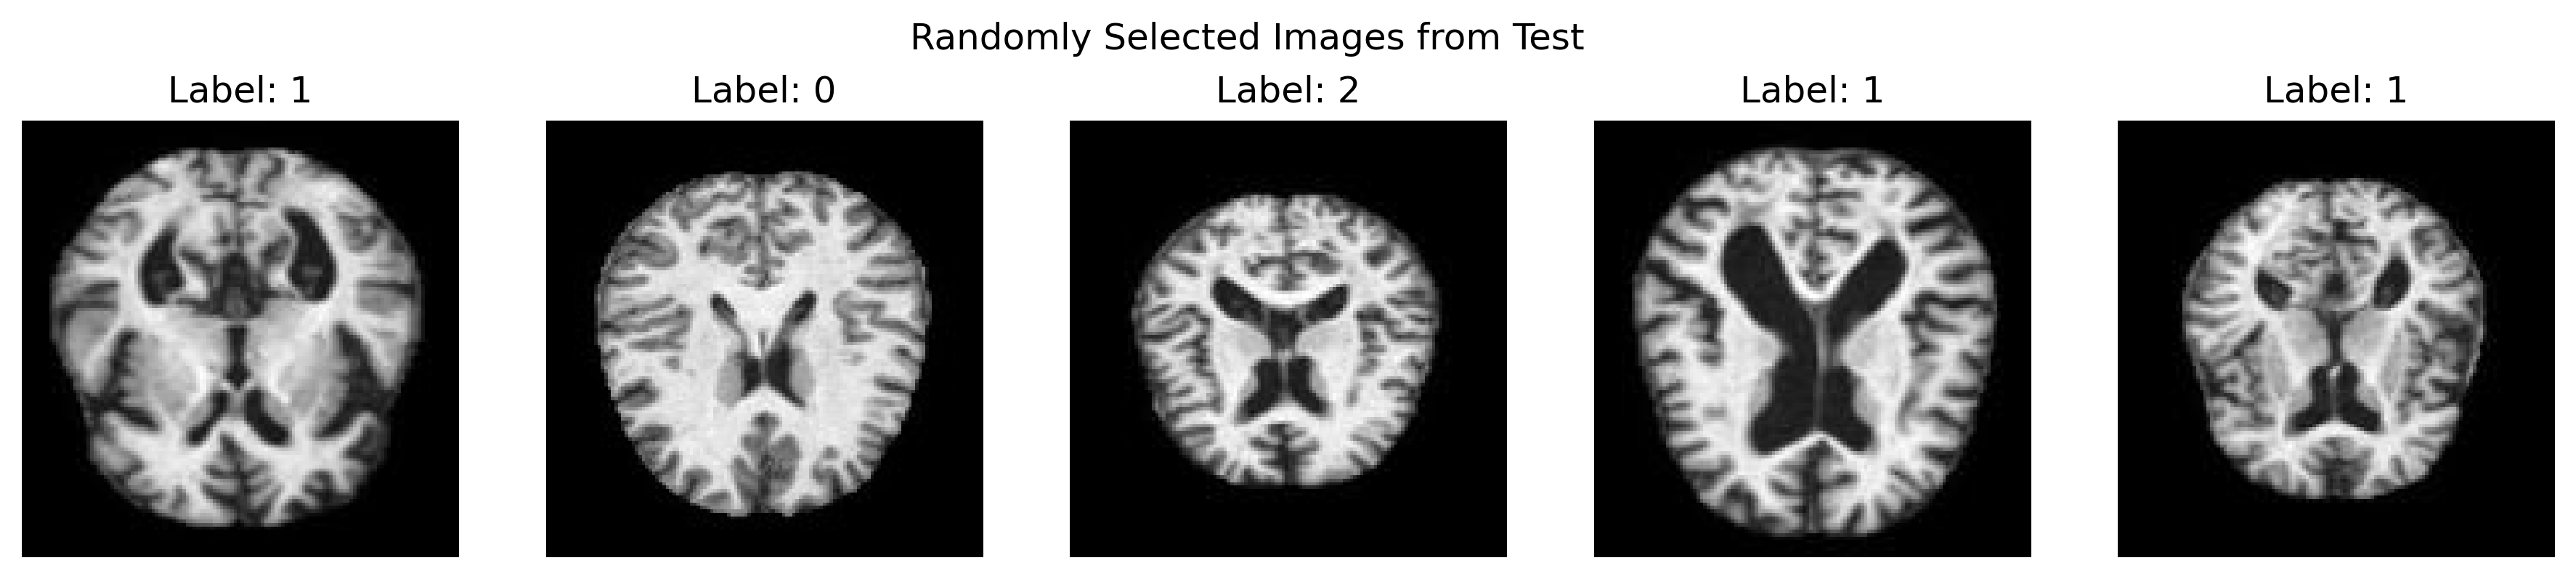

In [ ]:
import random
import matplotlib.pyplot as plt

def display_images_with_labels(images, labels, subset_name):
    # Randomly select 5 indices
    indices = random.sample(range(len(images)), 5)

    # Display the images and labels
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.suptitle(f"Randomly Selected Images from {subset_name}")
    plt.show()

# Display images from the train set
display_images_with_labels(train_images, train_labels, "Train")

# Display images from the validation set
display_images_with_labels(val_images, val_labels, "Validation")

# Display images from the test set
display_images_with_labels(test_images, test_labels, "Test")


#Mobile Net V1Model

In [ ]:
from tensorflow.keras.layers import Input, AvgPool2D, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

input_shape = (128,128,3)

input_layer = Input(shape = input_shape )


#Convolutional Block 1
x = Conv2D(16 , kernel_size=2, strides=1, padding='same', name= 'Conv1', input_shape=input_shape)(input_layer)
x = BatchNormalization (name='bn_Conv1')(x)
x = ReLU(name='Conv1_relu')(x)



# Depthwise Separable Convolution Block 1 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv1' )(x)
x = BatchNormalization (name='bn_DepthwiseConv1')(x)
x = ReLU(name='DepthwiseConv1_relu')(x)

x = Conv2D(16, kernel_size=1, padding='same', name='PointwiseConv1')(x)
x = BatchNormalization (name='bn_PointwiseConv1')(x)

# Depthwise Separable Convolution Block 2 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv2' )(x)
x = BatchNormalization (name='bn_DepthwiseConv2')(x)
x = ReLU(name='DepthwiseConv2_relu')(x)

x = Conv2D(30, kernel_size=1, padding='same', name='PointwiseConv2')(x)
x = BatchNormalization (name='bn_PointwiseConv2')(x)
x = AvgPool2D(pool_size=3, strides=1)(x)

#x = Dropout(0.5)(x)
# Depthwise Separable Convolution Block 3 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv3' )(x)
x = BatchNormalization (name='bn_DepthwiseConv3')(x)
x = ReLU(name='DepthwiseConv3_relu')(x)

x = Conv2D(50, kernel_size=1, padding='same', name='PointwiseConv3')(x)
x = BatchNormalization (name='bn_PointwiseConv3')(x)


"""
#Convolutional Block 2
x = Conv1D(96 , kernel_size=3, strides=2, padding='same', name= 'Conv2')(x)
x = BatchNormalization (name='bn_Conv2')(x)
x = ReLU(name='Conv2_relu')(x)
"""

# Depthwise Separable Convolution Block 4 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv4' )(x)
x = BatchNormalization (name='bn_DepthwiseConv4')(x)
x = ReLU(name='DepthwiseConv4_relu')(x)

x = Conv2D(70, kernel_size=1, padding='same', name='PointwiseConv4')(x)
x = BatchNormalization (name='bn_PointwiseConv4')(x)
x = AvgPool2D(pool_size=3, strides=1)(x)

# Depthwise Separable Convolution Block 5 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv5' )(x)
x = BatchNormalization (name='bn_DepthwiseConv5')(x)
x = ReLU(name='DepthwiseConv5_relu')(x)

x = Conv2D(80, kernel_size=1, padding='same', name='PointwiseConv5')(x)
x = BatchNormalization (name='bn_PointwiseConv5')(x)



# Depthwise Separable Convolution Block 6 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv6' )(x)
x = BatchNormalization (name='bn_DepthwiseConv6')(x)
x = ReLU(name='DepthwiseConv6_relu')(x)

x = Conv2D(100, kernel_size=1, padding='same', name='PointwiseConv6')(x)
x = BatchNormalization (name='bn_PointwiseConv6')(x)
x = AvgPool2D(pool_size=3, strides=1)(x)
"""
#Convolutional Block 3
x = Conv1D(156 , kernel_size=3, strides=2, padding='same', name= 'Conv3')(x)
x = BatchNormalization (name='bn_Conv3')(x)
x = ReLU(name='Conv3_relu')(x)
"""
#x = Dropout(0.5)(x)

# Depthwise Separable Convolution Block 7 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv7' )(x)
x = BatchNormalization (name='bn_DepthwiseConv7')(x)
x = ReLU(name='DepthwiseConv7_relu')(x)

x = Conv2D(110, kernel_size=1, padding='same', name='PointwiseConv7')(x)
x = BatchNormalization (name='bn_PointwiseConv7')(x)


# Depthwise Separable Convolution Block 8 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv8' )(x)
x = BatchNormalization (name='bn_DepthwiseConv8')(x)
x = ReLU(name='DepthwiseConv8_relu')(x)

x = Conv2D(120, kernel_size=1, padding='same', name='PointwiseConv8')(x)
x = BatchNormalization (name='bn_PointwiseConv8')(x)
x = AvgPool2D(pool_size=3, strides=1)(x)


# Depthwise Separable Convolution Block 9 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv9' )(x)
x = BatchNormalization (name='bn_DepthwiseConv9')(x)
x = ReLU(name='DepthwiseConv9_relu')(x)

x = Conv2D(130, kernel_size=1, padding='same', name='PointwiseConv')(x)
x = BatchNormalization (name='bn_PointwiseConv9')(x)



# Depthwise Separable Convolution Block 10 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv10' )(x)
x = BatchNormalization (name='bn_DepthwiseConv10')(x)
x = ReLU(name='DepthwiseConv10_relu')(x)

x = Conv2D(150, kernel_size=1, padding='same', name='PointwiseConv10')(x)
x = BatchNormalization (name='bn_PointwiseConv10')(x)
x = AvgPool2D(pool_size=3, strides=1)(x)

x = Dropout(0.5)(x)

# Depthwise Separable Convolution Block 11 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv11' )(x)
x = BatchNormalization (name='bn_DepthwiseConv11')(x)
x = ReLU(name='DepthwiseConv11_relu')(x)

x = Conv2D(170, kernel_size=1, padding='same', name='PointwiseConv11')(x)
x = BatchNormalization (name='bn_PointwiseConv11')(x)

# Depthwise Separable Convolution Block 12 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv12' )(x)
x = BatchNormalization (name='bn_DepthwiseConv12')(x)
x = ReLU(name='DepthwiseConv12_relu')(x)

x = Conv2D(190, kernel_size=1, padding='same', name='PointwiseConv12')(x)
x = BatchNormalization (name='bn_PointwiseConv12')(x)
x = AvgPool2D(pool_size=3, strides=2)(x)

# Depthwise Separable Convolution Block 13 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv13' )(x)
x = BatchNormalization (name='bn_DepthwiseConv13')(x)
x = ReLU(name='DepthwiseConv13_relu')(x)

x = Conv2D(200, kernel_size=1, padding='same', name='PointwiseConv13')(x)
x = BatchNormalization (name='bn_PointwiseConv13')(x)

# Depthwise Separable Convolution Block 14 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv14' )(x)
x = BatchNormalization (name='bn_DepthwiseConv14')(x)
x = ReLU(name='DepthwiseConv14_relu')(x)

x = Conv2D(220, kernel_size=1, padding='same', name='PointwiseConv14')(x)
x = BatchNormalization (name='bn_PointwiseConv14')(x)
x = AvgPool2D(pool_size=3, strides=2)(x)

# Depthwise Separable Convolution Block 15 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv15' )(x)
x = BatchNormalization (name='bn_DepthwiseConv15')(x)
x = ReLU(name='DepthwiseConv15_relu')(x)

x = Conv2D(230, kernel_size=1, padding='same', name='PointwiseConv15')(x)
x = BatchNormalization (name='bn_PointwiseConv15')(x)
#x = AvgPool2D(pool_size=3, strides=2)(x)

# Depthwise Separable Convolution Block 16 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv16' )(x)
x = BatchNormalization (name='bn_DepthwiseConv16')(x)
x = ReLU(name='DepthwiseConv16_relu')(x)

x = Conv2D(240, kernel_size=1, padding='same', name='PointwiseConv16')(x)
x = BatchNormalization (name='bn_PointwiseConv16')(x)
x = AvgPool2D(pool_size=3, strides=2)(x)

# Depthwise Separable Convolution Block 17 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv17' )(x)
x = BatchNormalization (name='bn_DepthwiseConv17')(x)
x = ReLU(name='DepthwiseConv17_relu')(x)

x = Conv2D(250, kernel_size=1, padding='same', name='PointwiseConv17')(x)
x = BatchNormalization (name='bn_PointwiseConv17')(x)

# Depthwise Separable Convolution Block 18 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv18' )(x)
x = BatchNormalization (name='bn_DepthwiseConv18')(x)
x = ReLU(name='DepthwiseConv18_relu')(x)

x = Conv2D(260, kernel_size=1, padding='same', name='PointwiseConv18')(x)
x = BatchNormalization (name='bn_PointwiseConv18')(x)
x = AvgPool2D(pool_size=3, strides=2)(x)

# Depthwise Separable Convolution Block 19 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv19' )(x)
x = BatchNormalization (name='bn_DepthwiseConv19')(x)
x = ReLU(name='DepthwiseConv19_relu')(x)

x = Conv2D(270, kernel_size=1, padding='same', name='PointwiseConv19')(x)
x = BatchNormalization (name='bn_PointwiseConv19')(x)

# Depthwise Separable Convolution Block 20 (expanded_conv)
x = DepthwiseConv2D(kernel_size=3, padding='same',name='DepthwiseConv20' )(x)
x = BatchNormalization (name='bn_DepthwiseConv20')(x)
x = ReLU(name='DepthwiseConv20_relu')(x)

x = Conv2D(280, kernel_size=1, padding='same', name='PointwiseConv20')(x)
x = BatchNormalization (name='bn_PointwiseConv20')(x)
x = AvgPool2D(pool_size=3, strides=2)(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Dropout layer before the final dense layer
x = Dropout(0.5)(x)

# Fully connected layer for classification
x = Dense(4, activation='softmax')(x) # for 4 classes

model = Model(inputs=input_layer, outputs=x)

model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 128, 128, 16)      208       
                                                                 
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 16)      64        
 on)                                                             
                                                                 
 Conv1_relu (ReLU)           (None, 128, 128, 16)      0         
                                                                 
 DepthwiseConv1 (DepthwiseC  (None, 128, 128, 16)      160       
 onv2D)                                                          
                                                                 
 bn_DepthwiseConv1 (BatchNo  (None, 128, 128, 16)      64  

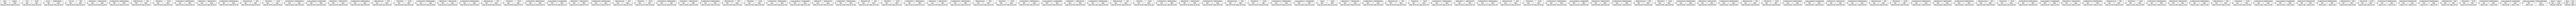

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming you have a 'model' variable representing your Keras model

# Set the desired DPI (adjust the value according to your needs)
dpi_value =50  # 96 is the standard screen DPI

# Set rankdir to 'LR' for horizontal layout
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=dpi_value, rankdir='LR') #LR indicates left to right orientation.

#Compiling and Fitting the Model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

NameError: ignored

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from keras.utils import to_categorical

# Assuming your classes are represented by integers (0, 1, 2, 3)
# If your classes are represented differently, adjust the `num_classes` parameter accordingly

num_classes = 4  # Adjust this based on the number of classes in your problem

# One-hot encode the labels
train_labels_one_hot = to_categorical(train_labels, num_classes=num_classes)
val_labels_one_hot = to_categorical(val_labels, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=num_classes)


In [ ]:
print(test_labels_one_hot[200])

[1. 0. 0. 0.]


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Other import statements and code...

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/My Drive/Alzheimers_Mobile_Net_v1/{val_accuracy:.3f}', save_weights_only=False)
]



In [ ]:
history = model.fit(train_images, train_labels_one_hot, batch_size=25, epochs=30, verbose=1, validation_data=(val_images, val_labels_one_hot), callbacks=callbacks)


Epoch 1/30
 83/116 [====================>.........] - ETA: 23:20 - loss: 1.0403 - accuracy: 0.4867

KeyboardInterrupt: ignored

#Visualizations

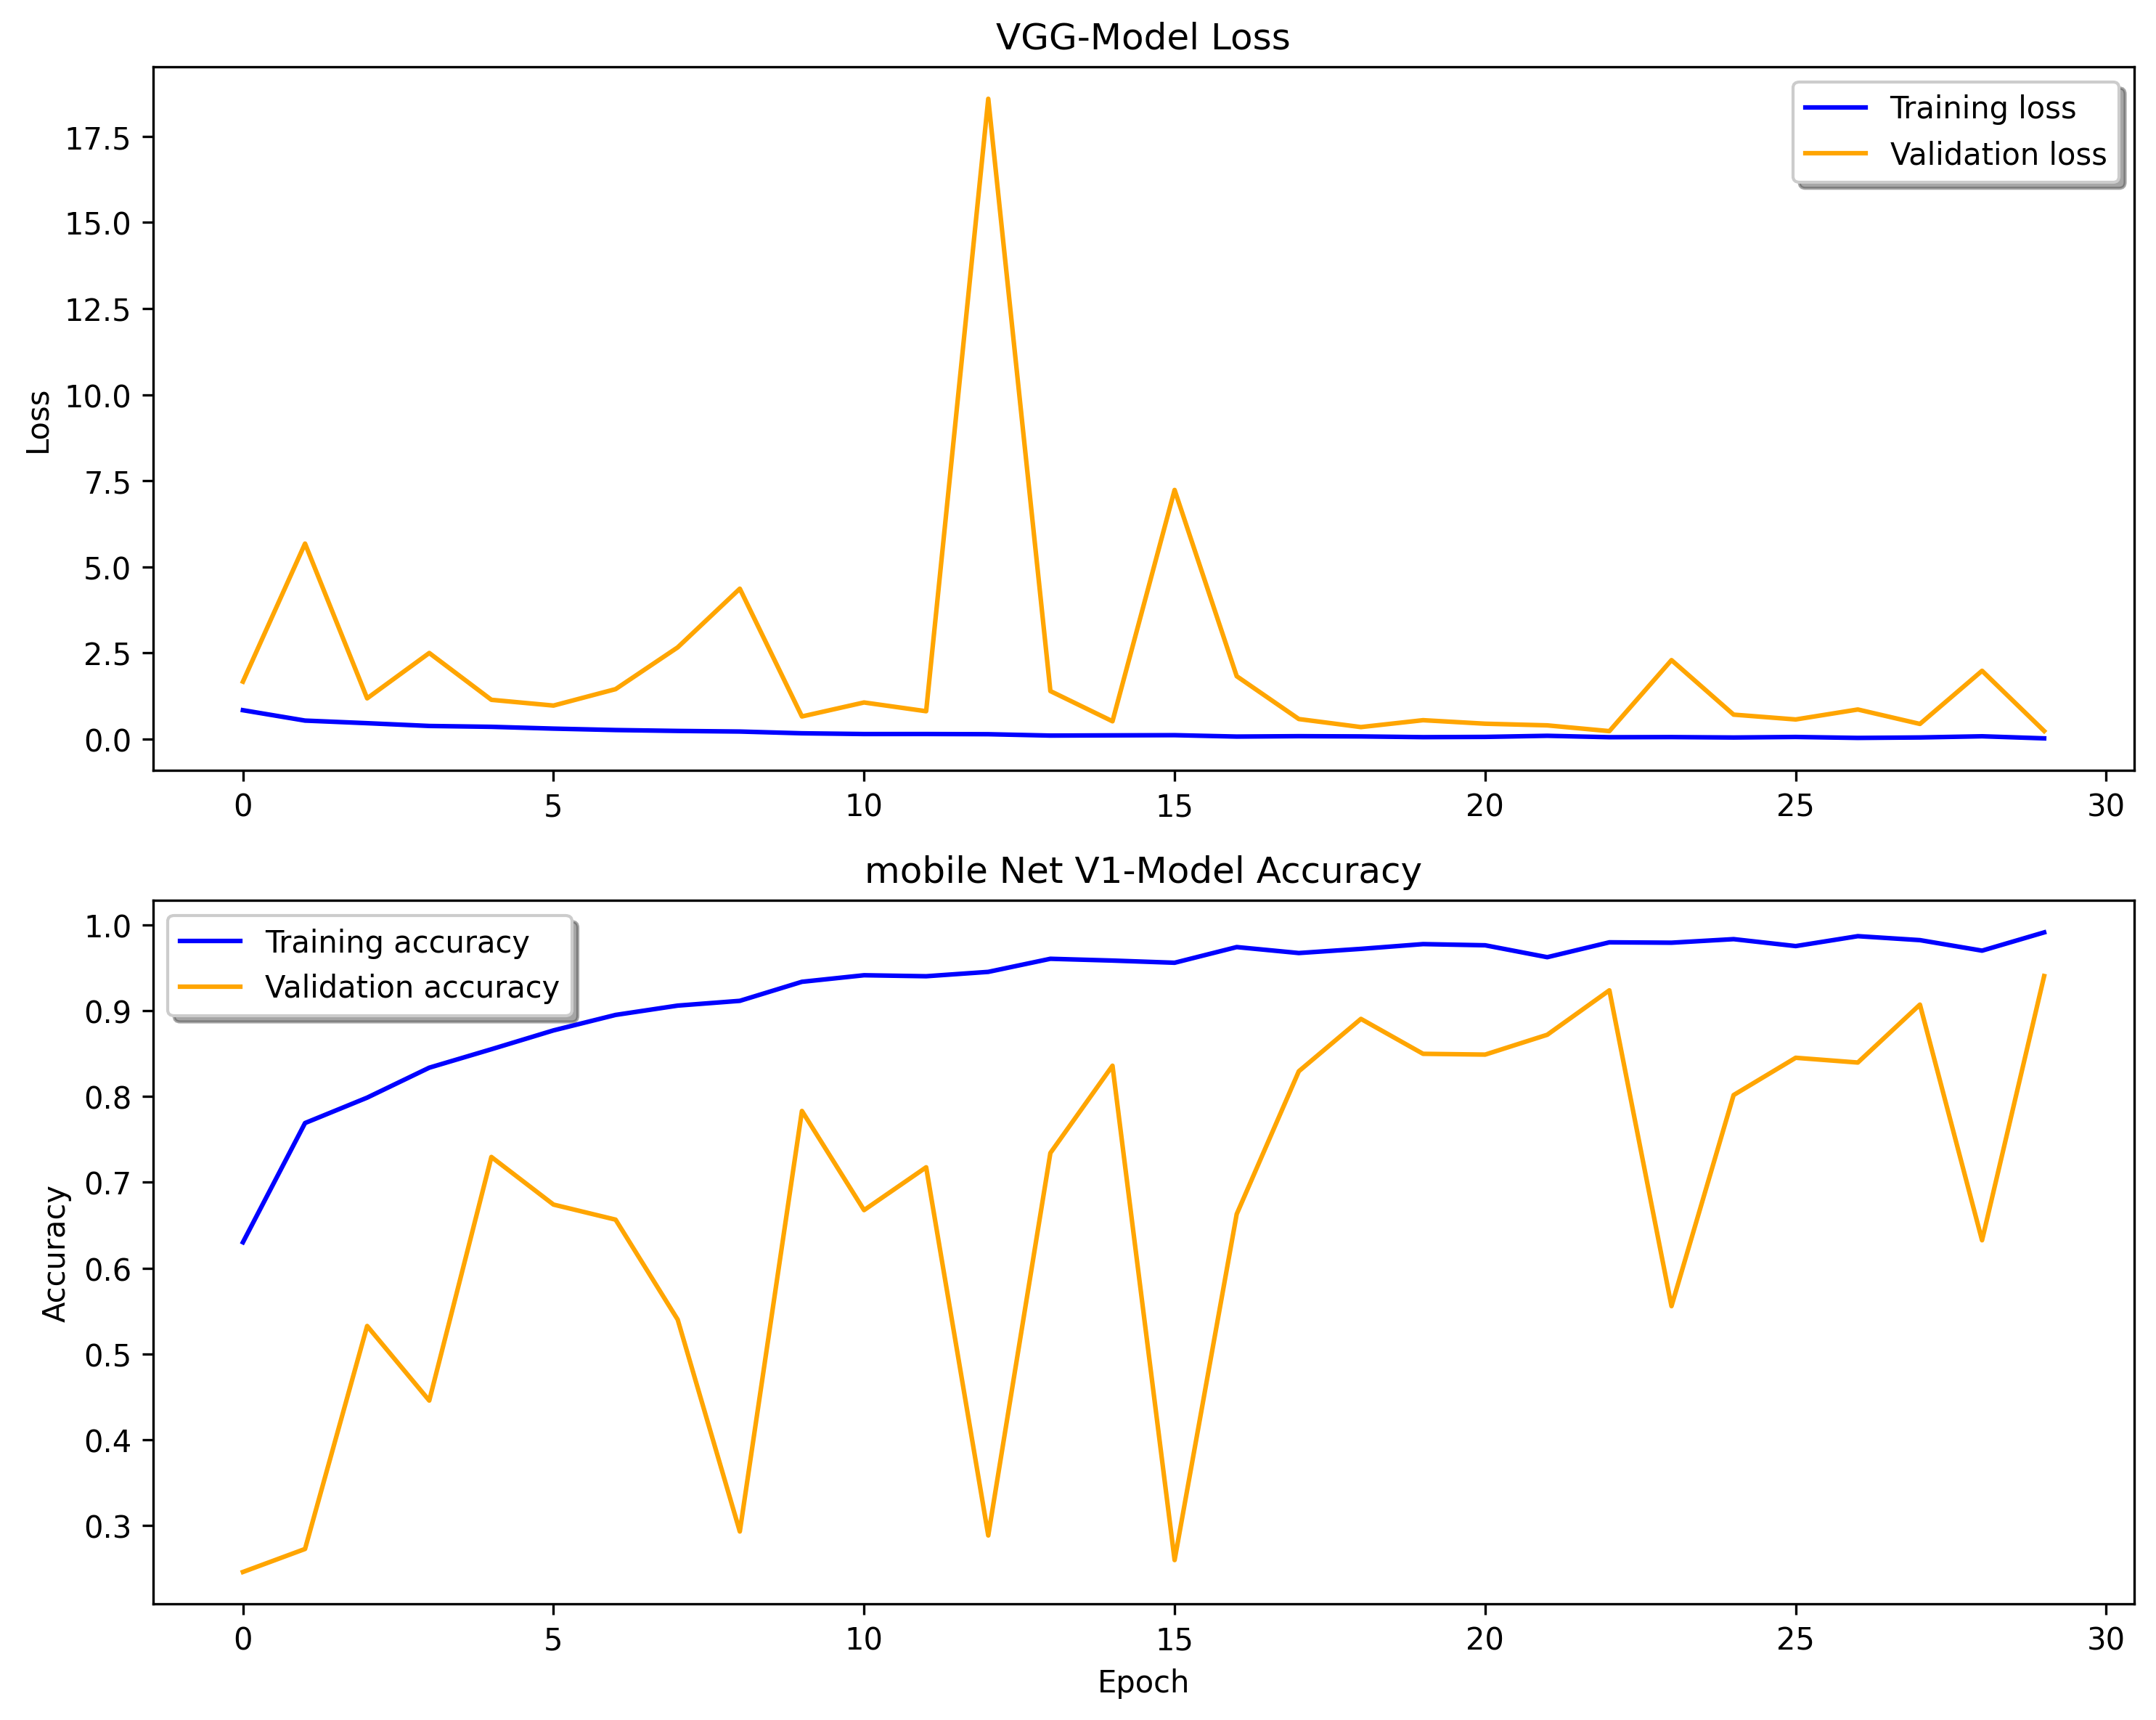

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' contains your training history data

# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot training and validation loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='orange', label="Validation loss")
ax[0].set_title('VGG-Model Loss')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best', shadow=True)

# Plot training and validation accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='orange', label="Validation accuracy")
ax[1].set_title('mobile Net V1-Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

In [ ]:
model_c1=tf.keras.models.load_model('/content/drive/My Drive/Alzheimers_Mobile_Net_v1/{}'.format('0.943'))

In [ ]:
score = model_c1.evaluate(test_images, test_labels_one_hot)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 147s 11s/step - loss: 0.0543 - accuracy: 0.9800
Test Loss: 0.05432828515768051
Test accuracy: 0.9800000190734863


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the true labels for the test set
y_true = np.argmax(test_labels_one_hot, axis=1)

# Assuming `model_c1` is your classifier model
predictions = model_c1.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Create the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

class_names =["1","2","3","4"]

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


13/13 [==============================] - 156s 12s/step
              precision    recall  f1-score   support

           1       0.95      1.00      0.98       100
           2       0.97      1.00      0.99       100
           3       1.00      1.00      1.00       100
           4       1.00      0.92      0.96       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



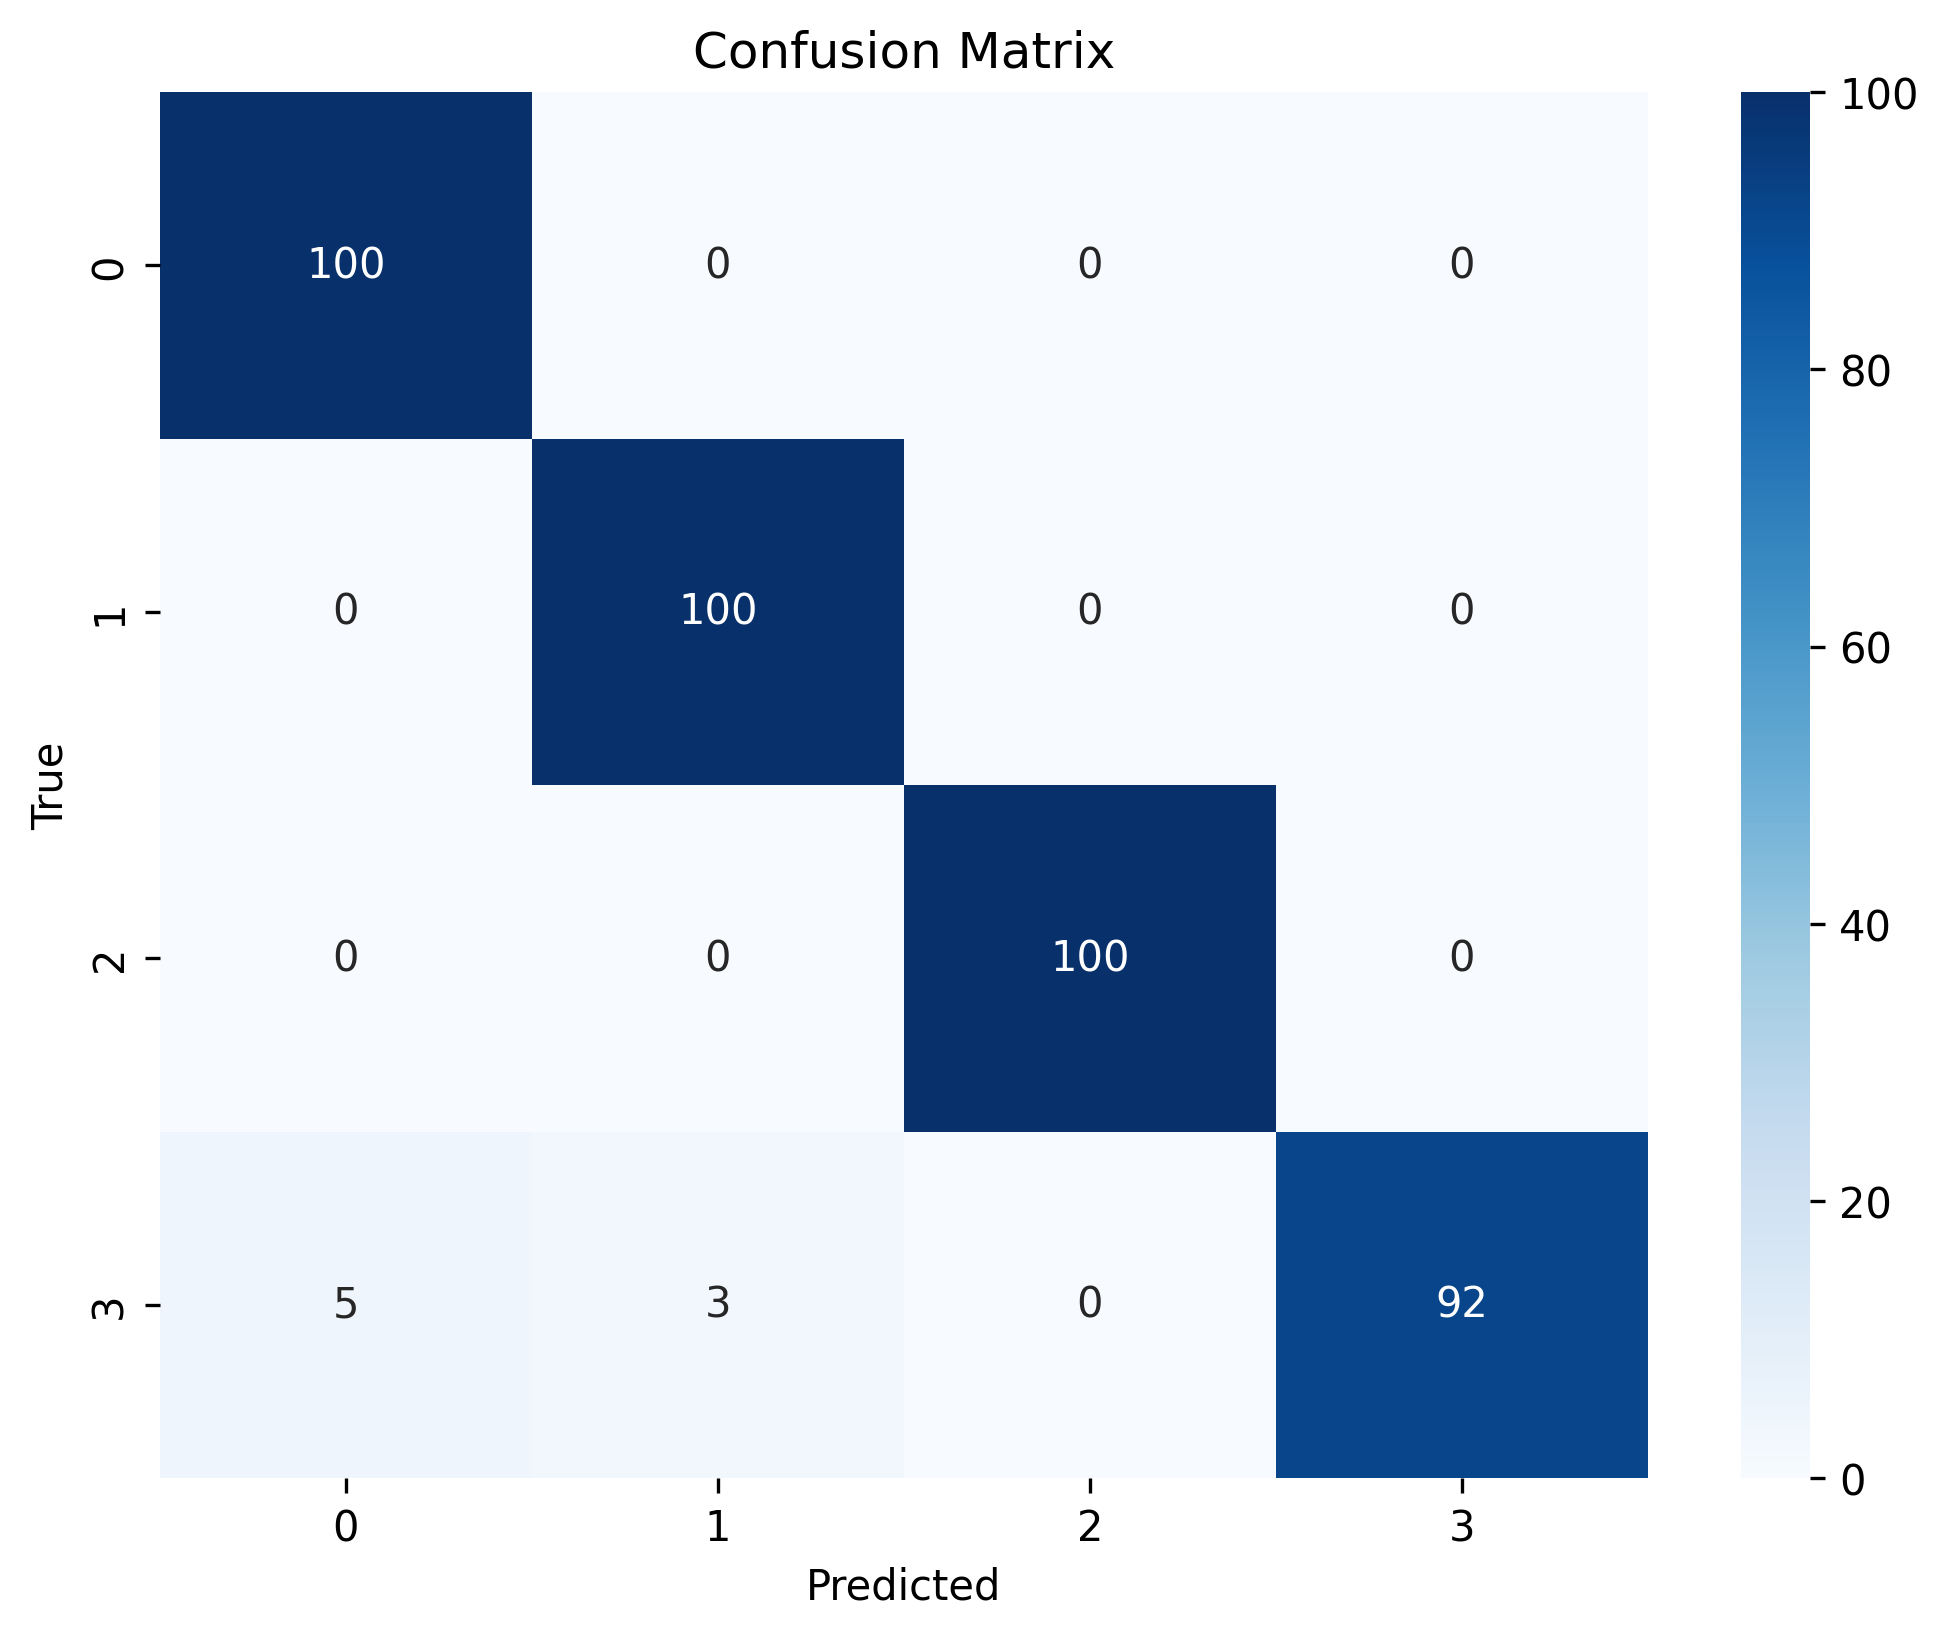

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()